## Import Desired Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import gc
import psutil
import os
import time
import matplotlib.pyplot as plt


## Create Dataset Class

In [2]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        # Here `encodings` will be a dictionary that contains 'input_ids' and 'attention_mask'
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx]),
        }

    def __len__(self):
        return len(self.input_ids)

## Funtion to calculate the memory consumed by Model

In [4]:
def calculate_model_memory(model, quantized=False):
    """
    Calculates the memory usage of the model. If quantized is True, it assumes
    that the model weights are quantized to 8 bits.
    
    Parameters:
    - model: The PyTorch model
    - quantized: Whether the model is quantized to 8-bits (True) or not (False)
    
    Returns:
    - Memory usage in MB
    """
    total_params = sum(p.numel() for p in model.parameters())
    
    # If the model is quantized to 8 bits (1 byte per parameter), we calculate memory accordingly
    if quantized:
        param_size_in_bytes = 1  # 1 byte per parameter for 8-bit quantization
    else:
        param_size_in_bytes = 4  # 4 bytes per parameter for 32-bit floating point

    total_memory = total_params * param_size_in_bytes / (1024 * 1024)  # Convert bytes to MB
    return total_memory

In [5]:
def calculate_model_memory_layers(model, quantized_layers=None):
    """
    Calculate memory usage of the model, taking into account selective quantization.
    
    quantized_layers: A list of layer names to be quantized, e.g., ['attn', 'mlp']
    """
    total_params = 0
    total_memory = 0
    
    for name, param in model.named_parameters():
        num_params = param.numel()
        
        if quantized_layers and any(layer_name in name for layer_name in quantized_layers):
            # Quantized layer (8-bit = 1 byte per parameter)
            total_memory += num_params * 1  # 1 byte per param for quantized layers
        else:
            # Non-quantized layer (32-bit = 4 bytes per parameter)
            total_memory += num_params * 4  # 4 bytes per param for non-quantized layers
        
        total_params += num_params
    
    total_memory_mb = total_memory / (1024 * 1024)  # Convert bytes to MB
    return total_memory_mb

## Prepare the Dataset

In [11]:
def prepare_dataset(tokenizer, max_length=512, num_samples=3000):
    # Load dataset and tokenize
    dataset = load_dataset("wikipedia", "20220301.en", split=f"train[:{num_samples}]")

    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

    # Apply tokenization
    encodings = dataset.map(tokenize_function, batched=True)
    return encodings

## Function to Calculate Perplexity and Measure Latency

In [12]:
def calculate_perplexity(model, eval_dataloader, device):
    model.eval()
    total_loss = 0
    total_length = 0

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Calculating perplexity"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss * attention_mask.sum()

            total_loss += loss.item()
            total_length += attention_mask.sum().item()

    return torch.exp(torch.tensor(total_loss / total_length))

In [13]:

def measure_inference_latency(model, input_ids, attention_mask, num_runs=200):
    latencies = []
    model.eval()

    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    with torch.no_grad():
        # Warmup
        for _ in range(10):
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            _ = model(input_ids, attention_mask=attention_mask)

        # Measure latency
        for _ in tqdm(range(num_runs), desc="Measuring latency"):
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start_time = time.perf_counter()
            _ = model(input_ids, attention_mask=attention_mask)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            latencies.append((time.perf_counter() - start_time) * 1000)

    return np.mean(latencies), np.std(latencies)

## Function to Quantise the Model

In [14]:
class CustomQuantizer:
    def __init__(self, model, bits=8):
        self.model = model
        self.bits = bits
        self.scaling_factors = {}
        self.original_weights = {}

    def quantize_tensor(self, tensor):
        max_val = tensor.abs().max()
        min_val = -max_val

        scale = (max_val - min_val) / (2**self.bits - 1)
        zero_point = (-min_val / scale).round()

        quantized = ((tensor / scale) + zero_point).round().clamp(0, 2**self.bits - 1)
        return quantized.to(torch.int8), scale, zero_point

    def dequantize_tensor(self, quantized, scale, zero_point):
        return scale * (quantized.float() - zero_point)

    def quantize_model(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.dim() > 1:
                self.original_weights[name] = param.data.clone()
                quantized, scale, zero_point = self.quantize_tensor(param.data)
                param.data = self.dequantize_tensor(quantized, scale, zero_point)
                self.scaling_factors[name] = (scale, zero_point)

    def selective_quantize(self, layers_to_quantize):
        for name, param in self.model.named_parameters():
            if any(layer_name in name for layer_name in layers_to_quantize) and param.requires_grad and param.dim() > 1:
                self.original_weights[name] = param.data.clone()
                quantized, scale, zero_point = self.quantize_tensor(param.data)
                param.data = self.dequantize_tensor(quantized, scale, zero_point)
                self.scaling_factors[name] = (scale, zero_point)

    def restore_model(self):
        for name, param in self.model.named_parameters():
            if name in self.original_weights:
                param.data = self.original_weights[name]

## Function to Plot the Result

In [15]:
def plot_results(results):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.bar(results["memory"]["labels"], results["memory"]["values"])
    ax1.set_title("Memory Usage (MB)")
    ax1.tick_params(axis='x', rotation=45)

    ax2.bar(results["perplexity"]["labels"], results["perplexity"]["values"])
    ax2.set_title("Perplexity")
    ax2.tick_params(axis='x', rotation=45)

    ax3.bar(results["latency"]["labels"], results["latency"]["values"])
    ax3.set_title("Latency (ms)")
    ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Using device: cuda


In [17]:
encodings = prepare_dataset(tokenizer)
eval_dataloader = DataLoader(TextDataset(encodings), batch_size=8, shuffle=False)
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

results = {
    "memory": {"labels": [], "values": []},
    "perplexity": {"labels": [], "values": []},
    "latency": {"labels": [], "values": []}
}

sample_batch = next(iter(eval_dataloader))

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


train-00006-of-00041.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

train-00009-of-00041.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00000-of-00041.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

train-00013-of-00041.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

train-00003-of-00041.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

train-00014-of-00041.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

train-00010-of-00041.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00004-of-00041.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00007-of-00041.parquet:   0%|          | 0.00/326M [00:00<?, ?B/s]

train-00011-of-00041.parquet:   0%|          | 0.00/247M [00:00<?, ?B/s]

train-00005-of-00041.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

train-00002-of-00041.parquet:   0%|          | 0.00/558M [00:00<?, ?B/s]

train-00015-of-00041.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

train-00001-of-00041.parquet:   0%|          | 0.00/705M [00:00<?, ?B/s]

train-00012-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00008-of-00041.parquet:   0%|          | 0.00/329M [00:00<?, ?B/s]

train-00016-of-00041.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

train-00017-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00018-of-00041.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00019-of-00041.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00020-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00021-of-00041.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00022-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00023-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00024-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00025-of-00041.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

train-00026-of-00041.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

train-00027-of-00041.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

train-00028-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00029-of-00041.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00030-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00031-of-00041.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

train-00032-of-00041.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

train-00033-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00034-of-00041.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

train-00035-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00036-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00037-of-00041.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00038-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00039-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00040-of-00041.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6458670 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [35]:
configs = [
        ("Original", None),
        ("Quantized", lambda m: CustomQuantizer(m, bits=8).quantize_model()),
        ("Selective Quantized", lambda m: CustomQuantizer(m, bits=8).selective_quantize(["attn", "mlp"]))
    ]

## Perform the Quantisation

In [38]:
for label, quantize_fn in configs:
    model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
    print(f"\nTesting {label} model...")

    # Apply quantization if quantize_fn is provided
    if quantize_fn:
        quantize_fn(model)

    # Handle Original model: No quantization
    if label == "Original":
        results["memory"]["labels"].append(label)
        results["memory"]["values"].append(calculate_model_memory(model))  


    # Handle fully Quantized model
    elif label == "Quantized":
        results["memory"]["labels"].append(label)
        results["memory"]["values"].append(calculate_model_memory(model,True))

        # Save the fully quantized model
        model.save_pretrained(f"{label}_model")  # Save the fully quantized model

    # Handle Selectively Quantized model
    elif label == "Selective Quantized":
        results["memory"]["labels"].append(label)
        results["memory"]["values"].append(calculate_model_memory_layers(model, quantized_layers=['attn', 'mlp']))

        # Save the selectively quantized model
        model.save_pretrained(f"{label}_model")  # Save the selectively quantized model

    # Calculate Perplexity
    perplexity = calculate_perplexity(model, eval_dataloader, device)
    results["perplexity"]["labels"].append(label)
    results["perplexity"]["values"].append(perplexity.item())

    # Measure Latency
    latency, _ = measure_inference_latency(
        model,
        sample_batch["input_ids"],
        sample_batch["attention_mask"]
    )
    results["latency"]["labels"].append(label)
    results["latency"]["values"].append(latency)

    # Restore the model to its original state if quantization was applied
    if quantize_fn:
        CustomQuantizer(model).restore_model()


Testing Original model...


Measuring latency: 100%|██████████| 200/200 [01:02<00:00,  3.21it/s]



Testing Quantized model...


Measuring latency: 100%|██████████| 200/200 [00:59<00:00,  3.35it/s]



Testing Selective Quantized model...


Measuring latency: 100%|██████████| 200/200 [01:00<00:00,  3.30it/s]


In [44]:
def print_results_summary(results):
    """
    Prints a summary of results (memory, perplexity, latency) for each model.
    
    Args:
    - results (dict): A dictionary containing metrics (memory, perplexity, latency),
                      with labels and values.
    """
    print("\nResults Summary:")
    for metric in results:
        print(f"{metric.title()}:")
        for label, value in zip(results[metric]["labels"], results[metric]["values"]):
            print(f"  {label}: {value:.2f}")

In [45]:
print_results_summary(results)


Results Summary:
Memory:
  Original: 474.70
  Quantized: 118.68
  Selective Quantized: 231.46
Perplexity:
  Original: 34.46
  Quantized: inf
  Selective Quantized: 402992.97
Latency:
  Original: 308.30
  Quantized: 295.77
  Selective Quantized: 300.16


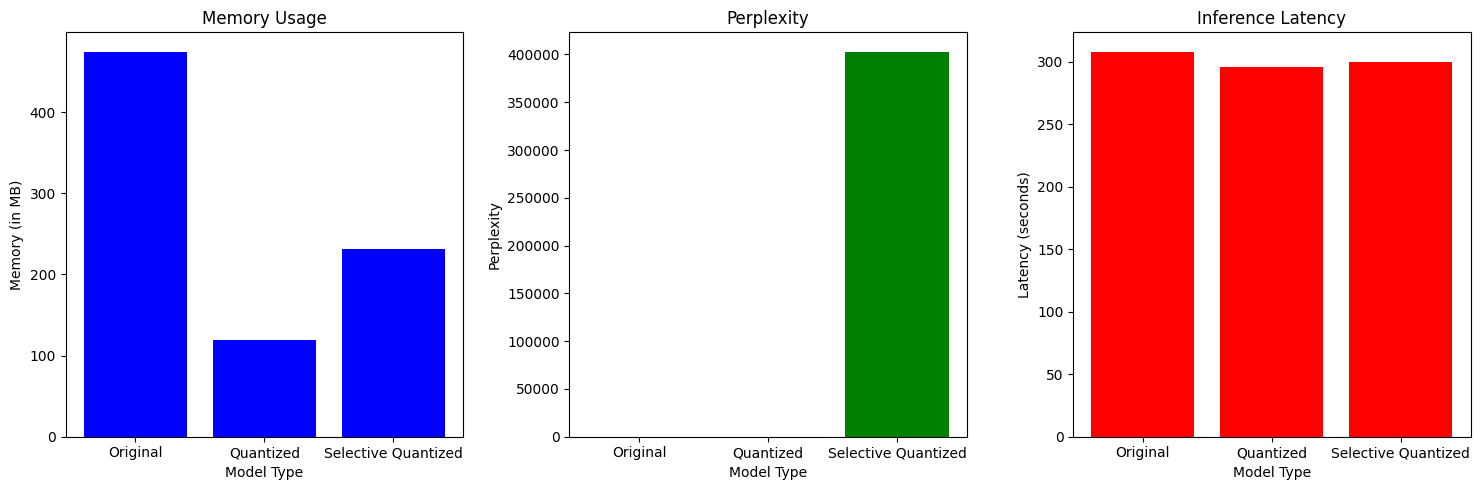

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Memory
axs[0].bar(results["memory"]["labels"], results["memory"]["values"], color='blue')
axs[0].set_title("Memory Usage")
axs[0].set_xlabel("Model Type")
axs[0].set_ylabel("Memory (in MB)")

# Plot Perplexity
axs[1].bar(results["perplexity"]["labels"], results["perplexity"]["values"], color='green')
axs[1].set_title("Perplexity")
axs[1].set_xlabel("Model Type")
axs[1].set_ylabel("Perplexity")

# Plot Latency
axs[2].bar(results["latency"]["labels"], results["latency"]["values"], color='red')
axs[2].set_title("Inference Latency")
axs[2].set_xlabel("Model Type")
axs[2].set_ylabel("Latency (seconds)")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
import shutil
import os

# Specify the directory you want to zip (in this case, /kaggle/working/)
working_dir = '/kaggle/working/'

# Specify the name of the zip file
zip_file = '/kaggle/working/working_directory.zip'

# Zip the contents of the working directory
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', working_dir)

# Confirm that the zip file has been created
os.listdir('/kaggle/working/')

['Selective Quantized_model',
 'Quantized_model',
 '.virtual_documents',
 'working_directory.zip']